# Pontos
가이아 학습 전 보안을 위한 시스템

In [259]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import random
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2

In [260]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## 하이퍼 파라미터

In [261]:
EPOCHS     = 300
BATCH_SIZE = 1

IMG_HEIGHT = 256
IMG_WIDTH = 256

MODEL_PATH = "modelFile/model.pth"

## FGSM 어택

In [262]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [263]:
def getPertubedImage(img_tensor, original_image, epsilon, model):
    img_tensor = img_tensor.unsqueeze(0)
    original_image = original_image.unsqueeze(0)
    img_tensor.requires_grad_(True)
    original_image.requires_grad_(True)
    output = model(img_tensor)
    
    loss_fn = torch.nn.MSELoss(reduction='sum')
    # 오차값 구하기 (레이블 263은 웰시코기)
    loss = loss_fn(output, original_image) 
    #print("기존 모델 오차 : " + str(loss.data))
    
    # 기울기값 구하기
    model.zero_grad()
    
    loss.requires_grad_(True)
    loss.backward()
    

    # 이미지의 기울기값을 추출
    #print(img_tensor.grad)
    gradient = img_tensor.grad.data
    perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)
    #print(perturbed_data.squeeze(0).size())
    return perturbed_data.squeeze(0)



## 데이터셋

In [264]:
# U-net 구조를 만들어보자

class Generator(nn.Module):
  def __init__(self, ngf=64): ### Question -> why self.conv_bn no?
    super(Generator, self).__init__()
    self.conv1 = nn.Conv2d(4, ngf, kernel_size=4, stride=2, padding=1) #(3, 256, 256)->(64, 128, 128)
    self.conv2 = nn.Conv2d(ngf, ngf*2, 4, 2, 1) #(64, 128, 128)->(128, 64, 64)
    self.conv2_bn = nn.BatchNorm2d(ngf*2) 
    self.conv3 = nn.Conv2d(ngf*2, ngf*4, 4, 2, 1) #(128, 64, 64)->(256, 32, 32)
    self.conv3_bn = nn.BatchNorm2d(ngf*4) 
    self.conv4 = nn.Conv2d(ngf*4, ngf*8, 4, 2, 1) #(256, 32, 32)->(512, 16, 16)
    self.conv4_bn = nn.BatchNorm2d(ngf*8) 
    self.conv5 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 16, 16)->(512, 8, 8)
    self.conv5_bn = nn.BatchNorm2d(ngf*8) 
    self.conv6 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 8, 8)->(512, 4, 4)
    self.conv6_bn = nn.BatchNorm2d(ngf*8) 
    self.conv7 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 4, 4)->(512, 2, 2)
    self.conv7_bn = nn.BatchNorm2d(ngf*8) 
    self.conv8 = nn.Conv2d(ngf*8, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 1, 1)
    self.conv8_bn = nn.BatchNorm2d(ngf*8) 

    self.deconv0 = nn.ConvTranspose2d(ngf*8, ngf*8, 4, 2, 1) #(512, 1, 1)->(512, 2, 2)  # concat 했으니까 수정해야함
    self.deconv0_bn = nn.BatchNorm2d(ngf*8) 
    self.deconv1 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 2, 2)->(512, 4, 4)
    self.deconv1_bn = nn.BatchNorm2d(ngf*8) 
    self.deconv2 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 4, 4)->(512, 8, 8)
    self.deconv2_bn = nn.BatchNorm2d(ngf*8) 
    self.deconv3 = nn.ConvTranspose2d(ngf*8*2, ngf*8, 4, 2, 1) #(512, 8, 8)->(512, 16, 16)
    self.deconv3_bn = nn.BatchNorm2d(ngf*8) 
    self.deconv4 = nn.ConvTranspose2d(ngf*8*2, ngf*4, 4, 2, 1) #(512, 16, 16)->(256, 32, 32)
    self.deconv4_bn = nn.BatchNorm2d(ngf*4) 
    self.deconv5 = nn.ConvTranspose2d(ngf*4*2, ngf*2, 4, 2, 1) #(256, 32, 32)->(128, 64, 64)
    self.deconv5_bn = nn.BatchNorm2d(ngf*2) 
    self.deconv6 = nn.ConvTranspose2d(ngf*2*2, ngf, 4, 2, 1) #(128, 64, 64)->(64, 128, 128)
    self.deconv6_bn = nn.BatchNorm2d(ngf) 
    self.deconv7 = nn.ConvTranspose2d(ngf*2, 4, 4, 2, 1) #(64, 128, 128)->(3, 256, 256)

    self.leaky = nn.LeakyReLU(0.2, True)
    self.relu = nn.ReLU(True)
    self.drop = nn.Dropout(0.5)

  def forward(self, input): # (3, 256, 256) <- input
    x1 = self.conv1(input) #(64, 128, 128)<- x1

    x2 = self.leaky(x1)
    x2 = self.conv2(x1)
    x2 = self.conv2_bn(x2)

    x3 = self.leaky(x2)   
    x3 = self.conv3(x3)
    x3 = self.conv3_bn(x3)

    x4 = self.leaky(x3)  
    x4 = self.conv4(x4)
    x4 = self.conv4_bn(x4)  

    x5 = self.leaky(x4)
    x5 = self.conv5(x5)    
    x5 = self.conv5_bn(x5)  

    x6 = self.leaky(x5)
    x6 = self.conv6(x6)    
    x6 = self.conv6_bn(x6)

    x7 = self.leaky(x6)
    x7 = self.conv7(x7)
    x7 = self.conv7_bn(x7)

    x8 = self.leaky(x7)
    x8 = self.conv8(x7)

    y1 = self.relu(x8)
    y1 = self.deconv0(y1)
    y1 = self.deconv0_bn(y1)
    y1 = self.drop(y1)
    y1 = torch.cat([y1,x7], dim=1)

    y2 = self.relu(y1)
    y2 = self.deconv1(y2)
    y2 = self.deconv1_bn(y2)
    y2 = self.drop(y2)
    y2 = torch.cat([y2,x6], dim=1)

    y3 = self.relu(y2)
    y3 = self.deconv2(y3)
    y3 = self.deconv2_bn(y3)
    y3 = self.drop(y3)
    y3 = torch.cat([y3,x5], dim=1)

    y4 = self.relu(y3)
    y4 = self.deconv3(y4)
    y4 = self.deconv3_bn(y4)
    y4 = torch.cat([y4,x4], dim=1)

    y5 = self.relu(y4)
    y5 = self.deconv4(y5)
    y5 = self.deconv4_bn(y5)
    y5 = torch.cat([y5,x3], dim=1)

    y6 = self.relu(y5)
    y6 = self.deconv5(y6)
    y6 = self.deconv5_bn(y6)
    y6 = torch.cat([y6,x2], dim=1)

    y7 = self.relu(y6)
    y7 = self.deconv6(y7)
    y7 = self.deconv6_bn(y7)
    y7 = torch.cat([y7,x1], dim=1)

    y8 = self.relu(y7)
    y8 = self.deconv7(y8)

    output = nn.Tanh()(y8)

    return output

In [265]:
generator = Generator()
generator.load_state_dict(torch.load("./modelFIle/g1.PTH"))
generator.eval()

Generator(
  (conv1): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(512, 512, kernel_size=(4, 

In [266]:
trainlist = [file for file in glob.glob(os.getcwd()+"/DatasetTrain/*") if file.endswith('.png') or file.endswith('.PNG')]
testlist = [file for file in glob.glob(os.getcwd()+"/DatasetTest/*") if file.endswith('.png') or file.endswith('.PNG')]

print(trainlist)

['D:\\Project-Gaea\\Pontos/DatasetTrain\\001-Fighter01.png', 'D:\\Project-Gaea\\Pontos/DatasetTrain\\002-Fighter02.png', 'D:\\Project-Gaea\\Pontos/DatasetTrain\\003-Fighter03.png', 'D:\\Project-Gaea\\Pontos/DatasetTrain\\004-Fighter04.png']


In [267]:
class imagedata:
  def __init__(self, path,  w = 128, h = 192):
    self.outp = Image.open(path).convert("RGBA")
    
    self.outp = self.outp.resize((w, h))
    area = (0, 0, int(w/4), int(h/4))
    self.inp = self.outp.crop(area)
    
    
    mresult = Image.new("RGBA",(w, int(h/4)))
    for i in range(0, 4):
        mresult.paste(im=self.inp, box=(int(w/4*i), 0))
    self.inp = Image.new("RGBA",(w, h))
    for i in range(0, 4):
        self.inp.paste(im=mresult, box=(0, int(h/4*i)))

In [268]:
class CustomDataset(Dataset): 
  def __init__(self, paths, model):
    self.x_data = []
    self.y_data = None
    self.mix = {}
    self.model = model
    
    for path in paths:
        imgd = imagedata(path)
        img_transforms = transforms.Compose([
            transforms.Resize((256, 256), Image.BICUBIC),
            transforms.ToTensor(),
        ])
        img_tensor = img_transforms(imgd.inp)
        imgp_tensor = img_transforms(imgd.outp)
        #img_tensor = img_tensor.unsqueeze(0)
        #imgp_tensor = imgp_tensor.unsqueeze(0)
        #print(img_tensor.size())
        self.x_data.append(img_tensor)
        self.mix[img_tensor]=imgp_tensor

  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    if random.randint(0, 1) == 0 :
        #왜곡 X
        x = self.x_data[idx]
        y = torch.tensor(0)
    else :
        #왜곡 O
        x = self.x_data[idx]
        x = getPertubedImage(x, self.mix[x], random.uniform(0.01, 0.9), self.model)
        #x = fgsm_attack(img_tensor, epsilon, gradient)
        y = torch.tensor(1)
    #print(x.size())
    #print(y.size())
    return x, y

In [269]:
train_loader = DataLoader(CustomDataset(trainlist, generator), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(CustomDataset(testlist, generator), batch_size=1, shuffle=True)

In [270]:
#print(datas.targets)        
print("< DATA >")
i = 0
for batch_idx, (datax, target) in enumerate(train_loader):
    print("x : " + str(datax.data) + "\n\n\n")
    print("y : " + str(target.data))
    print("x size : " + str(datax.size()) + "\n\n\n")
    print("y size : " + str(target.size()))
    i+=1
    if i == 1:
        break

< DATA >
x : tensor([[[[0.0593, 0.0593, 0.0593,  ..., 0.0000, 0.0593, 0.0593],
          [0.0000, 0.0000, 0.0593,  ..., 0.0593, 0.0593, 0.0000],
          [0.0593, 0.0593, 0.0000,  ..., 0.0593, 0.0593, 0.0000],
          ...,
          [0.0593, 0.0000, 0.0593,  ..., 0.0000, 0.0593, 0.0000],
          [0.0000, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0000],
          [0.0593, 0.0000, 0.0000,  ..., 0.0593, 0.0593, 0.0000]],

         [[0.0000, 0.0593, 0.0593,  ..., 0.0593, 0.0000, 0.0593],
          [0.0593, 0.0593, 0.0593,  ..., 0.0000, 0.0593, 0.0593],
          [0.0000, 0.0593, 0.0000,  ..., 0.0593, 0.0593, 0.0000],
          ...,
          [0.0593, 0.0593, 0.0000,  ..., 0.0000, 0.0593, 0.0593],
          [0.0000, 0.0000, 0.0000,  ..., 0.0593, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0593,  ..., 0.0593, 0.0593, 0.0000]],

         [[0.0593, 0.0000, 0.0593,  ..., 0.0593, 0.0593, 0.0593],
          [0.0000, 0.0593, 0.0593,  ..., 0.0593, 0.0593, 0.0000],
          [0.0593, 0.0000, 0.

## ResNet

In [271]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(4, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(4096, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.size())
        out = F.relu(self.bn1(self.conv1(x)))
        #print(out.size())
        out = self.layer1(out)
        #print(out.size())
        out = self.layer2(out)
        #print(out.size())
        out = self.layer3(out)
        #print(out.size())
        out = F.avg_pool2d(out, 8)
        #print(out.size())
        out = out.view(out.size(0), -1)
        #print(out.size())
        out = self.linear(out)
        #print(out.size())
        return out

## Train

In [274]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        #print("Train")
        output = model(data)
        #target=torch.argmax(target, dim=0)
        #print("--------------------------------------------------------------------------")
        #print("결과 : " + str(output))
        #print("결과 사이즈 : " + str(output.size()))
        #print("타겟 : " + str(target))
        #print("타겟 사이즈 : " + str(target.size()))
        #print("--------------------------------------------------------------------------")
        
        #loss = F.cross_entropy(output, torch.max(target,1)[1])
        loss = F.cross_entropy(output, target)
        
        loss.backward()
        optimizer.step()
        
        
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    print("test start")
    '''
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            #target=torch.argmax(target, dim=0)
            #print(output)
            #print(target)
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
'''
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)

        test_loss += F.cross_entropy(output, target, reduction='sum').item()

        # 가장 높은 값을 가진 인덱스가 바로 예측값
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        print('--------------------------------------------------------------------------------------------------------')
        pic = np.transpose(data.detach().numpy()[0], (1, 2, 0))
        plt.imshow(pic)
        plt.show()
        print("예측한 답안 : " + str(pred.data))
        print("실제 답안 : " + str(target.data))
        
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 실행

test start
--------------------------------------------------------------------------------------------------------


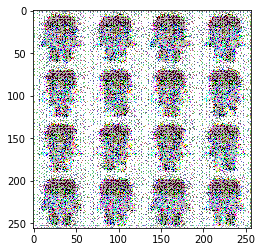

예측한 답안 : tensor([[1]])
실제 답안 : tensor([1])
--------------------------------------------------------------------------------------------------------


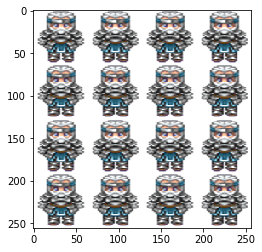

예측한 답안 : tensor([[1]])
실제 답안 : tensor([0])

[1] Test Loss: 75.6640, Accuracy: 50.00%
--------------------------------------------------------------------------------------------------------
test start
--------------------------------------------------------------------------------------------------------


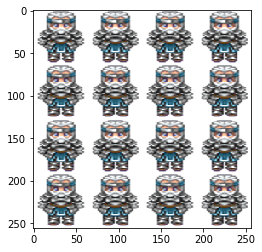

예측한 답안 : tensor([[1]])
실제 답안 : tensor([0])
--------------------------------------------------------------------------------------------------------


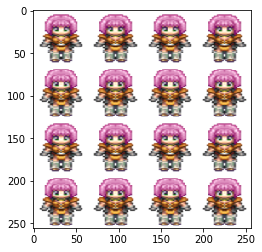

예측한 답안 : tensor([[1]])
실제 답안 : tensor([0])

[2] Test Loss: 8708519374532276098433024.0000, Accuracy: 0.00%
--------------------------------------------------------------------------------------------------------
test start
--------------------------------------------------------------------------------------------------------


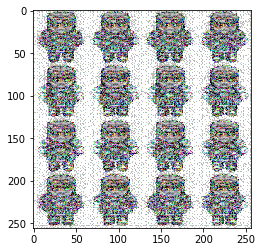

예측한 답안 : tensor([[1]])
실제 답안 : tensor([1])
--------------------------------------------------------------------------------------------------------


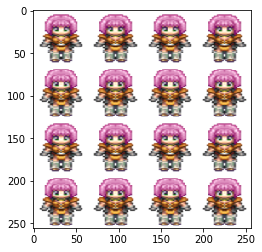

예측한 답안 : tensor([[1]])
실제 답안 : tensor([0])

[3] Test Loss: 19072968704.0000, Accuracy: 50.00%
--------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [275]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('\n[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
    print('--------------------------------------------------------------------------------------------------------')